# Quantizing LLMs for INT4/8 Inference

As models continue to grow in size, the demand for improved quantization techniques becomes increasingly essential. But what exactly is quantization? Quantization involves representing model parameters in lower precision. For instance, instead of the commonly used float32, utilizing float16 to represent model weights can halve the storage requirements. Moreover, it enhances performance by reducing computational load when operating at lower precision. However, one downside of quantization is a slight drop in model accuracy. This occurs because parameters have less representation power at lower precision. Essentially, with quantization, we trade accuracy for improved performance (both in terms of computation and storage) during inference.

When it comes to quantization, there are various methods available, but this sample focuses solely on Weight Only Quantization techniques (WOQ). Typically, both model weights and activations (output values generated by each neuron in a layer) are quantized. However, WOQ exclusively quantizes the model weights, leaving activations unchanged. In practice, WOQ yields performance benefits without significantly impacting accuracy.

HuggingFace's transformers library simplifies the quantization process by providing straightforward options. Users can simply set the `load_in_4bit` or `load_in_8bit` argument to `True` to enable quantization. However, there's a limitation: this feature is exclusive to CUDA GPUs. When these arguments are activated, a `BitsandBytes` configuration is automatically generated, which unfortunately only works on CUDA GPU devices. This poses a challenge for users operating on CPUs or non-CUDA devices.

To address this limitation, the Intel team developed Intel Extension for Transformers (ITREX), which enhances quantization support and offers additional optimizations for Intel CPU/GPU architectures. To utilize ITREX, users can import `AutoModelForCasualLM` from the ITREX library instead of the transformers library. This enables users to leverage quantization and other optimizations seamlessly, regardless of their hardware configuration.

We've extended the `from_pretrained` method to accommodate the `quantization_config`, which now accepts various configurations such as `RtnConfig`, `AwqConfig`, `TeqConfig`, `GPTQConfig`, and `AutoroundConfig` for implementing quantization on the CPU, along side CUDA GPUs. When you set the `load_in_4bit` or `load_in_8bit` argument to `True`, the behavior depends on your device configuration. If your device is set to CUDA, then `BitsAndBytesConfig` will be utilized. However, if your device is set to CPU, `RtnConfig`, which is specially optimized for Intel CPUs and GPUs, will be employed. This basically provides same interface for using Intel CPUs, Intel GPUs and CUDA devices, ensuring seamless quantization across different hardware configurations.

There is one caveat to note: not all model architectures are currently supported. Currently, only the most commonly used LLMs, which cover the majority of use cases, are supported. However, our team is actively working to optimize more models. For a comprehensive list of supported models, please refer to [this link](https://github.com/intel/neural-speed/blob/v0.3/docs/supported_models.md).

Enough with the theory. Let's dive into quantizing an LLM...

## Setup

To begin, ensure that you have AIkit installed and functioning correctly on your system. If you haven't installed AIkit yet, please follow the installation instructions provided [here](README.md). 

Use the commands below to verify that `Intel® Extension for Transformers (ITREX)` is properly installed:

In [ ]:
!python -c "import torch; import intel_extension_for_transformers as itrex; print(torch.__version__); print(itrex.__version__);"

## Quantizing LLM on Intel CPU

Lets start by importing ITREX and other libraries

In [1]:
from transformers import AutoTokenizer
from intel_extension_for_transformers.transformers import AutoModelForCausalLM

import matplotlib.pyplot as plt

/mnt/localdisk1/ankur/intel/oneapi/intelpython/envs/user_pytorch/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/mnt/localdisk1/ankur/intel/oneapi/intelpython/envs/user_pytorch/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


[2024-05-08 11:02:44,757] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cpu (auto detect)


**Note:** The code imports `AutoModelForCausalLM` from `intel_extension_for_transformers`, not from the Hugging Face `transformers` library.

Next, we'll initialize our tokenizer and tensor inputs for future usage.

In [2]:
model_name = "Intel/neural-chat-7b-v3-3"
prompt = "Once upon a time, a little girl"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
inputs = tokenizer(prompt, return_tensors="pt").input_ids

### Full Precision (32-bit Floating Point)

First, we will load the model in full precision (i.e. *float32*)

In [3]:
full_model = AutoModelForCausalLM.from_pretrained(model_name, use_neural_speed=False)
full_model.generate(inputs, max_new_tokens=50)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### INT4 (4-bit Integer)

To load model in INT4 precision, just set `load_in_4bit` to `True`.

In [4]:
q4_model = AutoModelForCausalLM.from_pretrained(
    model_name, load_in_4bit=True, use_neural_speed=False
)
q4_model.generate(inputs, max_new_tokens=50)

2024-05-08 11:04:28 [INFO] cpu device is used.
2024-05-08 11:04:28 [INFO] Applying Weight Only Quantization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-05-08 11:04:38.971277: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 11:04:38.971797: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 11:04:38.975091: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 11:04:39.015366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 11:04:39.764500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

tensor([[    1,  5713,  3714,   264,   727, 28725,   264,  1628,  2746,  5160,
         14003,   403,  7312,  1059,   272, 16748, 28723,   985,   403,   356,
           559,  1069,   298,  3251,   559, 19023, 28725,   693,  6262,   297,
           264,  1741,  2134,   438,   272,  5358,   302,   272,  8613, 28723,
          1136, 14003,  5610, 28725,   630,  8295,   264,  8708, 28725,  1272,
         15675,  2439,  5374,   778,   272,  7099, 28723,  6119,   925]])

The `from_pretrained` method call above, with `load_in_4bit=True`, initiates several actions. It downloads the model from the HuggingFace Hub, quantizes it, saves the quantized model for future use, and finally returns the model object. This process may take some time, but once completed, the model offers significantly improved throughput. The `use_neural_speed` argument will be discussed shortly; for now, set it to `False`.

### INT8 (8-bit Integer)

To load model in INT8 precision, just replace `load_in_4bit` with `load_in_8bit` and you should be good to go.

In [5]:
q8_model = AutoModelForCausalLM.from_pretrained(
    model_name, load_in_8bit=True, use_neural_speed=False
)
q8_model.generate(inputs, max_new_tokens=50)

2024-05-08 11:06:46 [INFO] cpu device is used.
2024-05-08 11:06:46 [INFO] Applying Weight Only Quantization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-05-08 11:06:56 [INFO] Start auto tuning.
2024-05-08 11:06:56 [INFO] Quantize model without tuning!
2024-05-08 11:06:56 [INFO] Quantize the model with default configuration without evaluating the model.                To perform the tuning process, please either provide an eval_func or provide an                    eval_dataloader an eval_metric.
2024-05-08 11:06:56 [INFO] Adaptor has 5 recipes.
2024-05-08 11:06:56 [INFO] 0 recipes specified by user.
2024-05-08 11:06:56 [INFO] 3 recipes require future tuning.
2024-05-08 11:06:56 [INFO] *** Initialize auto tuning
2024-05-08 11:06:56 [INFO] {
2024-05-08 11:06:56 [INFO]     'PostTrainingQuantConfig': {
2024-05-08 11:06:56 [INFO]         'AccuracyCriterion': {
2024-05-08 11:06:56 [INFO]             'criterion': 'relative',
2024-05-08 11:06:56 [INFO]             'higher_is_better': True,
2024-05-08 11:06:56 [INFO]             'tolerable_loss': 0.01,
2024-05-08 11:06:56 [INFO]             'absolute': None,
2024-05-08 11:06:56 [INFO]     

tensor([[    1,  5713,  3714,   264,   727, 28725,   264,  1628,  2746,  5160,
         14003,   403,  7312,  1059,   272, 16748, 28723,   985,   403,   356,
           559,  1069,   298,  3251,   559, 19023, 28725,   693,  6262,   297,
           264,  1741, 27270,  3534,  2373,   272,  8613, 28723,  1136, 14003,
          5610, 28725,   630,  8295,   264,  8708,  7739, 28747,   264,  8887,
          2251, 28725,   708,  9942,   821,   264,  1502, 28809, 28713]])

Lets check the model size in memory and disk

In [6]:
from utils import get_model_size_disk, get_model_size_ram

#### Size in Memory

full_model memory usage: 28649.023 MB
q8_model memory usage: 9556.578 MB
q4_model memory usage: 6206.328 MB


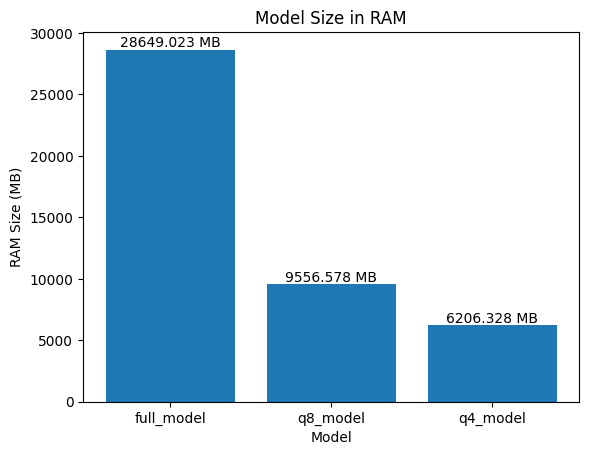

In [12]:
model_names = ["full_model", "q8_model", "q4_model"]
ram_sizes = [
    get_model_size_ram(full_model),
    get_model_size_ram(q8_model),
    get_model_size_ram(q4_model),
]

for model_name, ram_size in zip(model_names, ram_sizes):
    print(f"{model_name} memory usage: {ram_size/1024:.3f} GB")

plt.bar(model_names, ram_sizes)
plt.xlabel("Model")
plt.ylabel("RAM Size (GB)")
plt.title("Model Size in RAM")

# Add annotations at the top of the bar
for i, v in enumerate(ram_sizes):
    plt.text(i, v, f"{v/1024:.3f} GB", ha="center", va="bottom")

plt.show()

### Size in Disk

full_model disk usage: 28967.044 MB
q8_model disk usage: 8947.219 MB
q4_model disk usage: 5434.158 MB


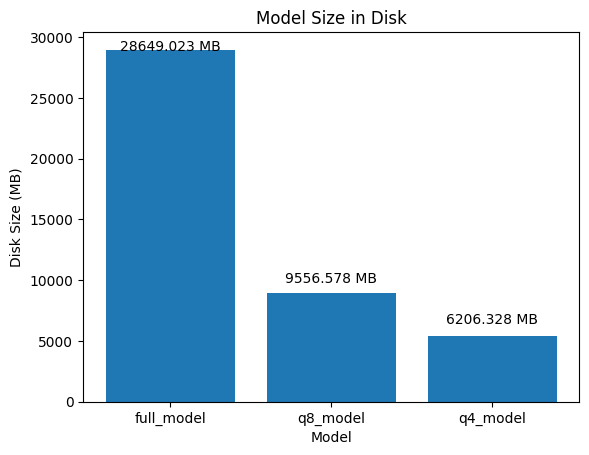

In [13]:
disk_sizes = [
    get_model_size_disk(full_model),
    get_model_size_disk(q8_model),
    get_model_size_disk(q4_model),
]

for model_name, disk_size in zip(model_names, disk_sizes):
    print(f"{model_name} disk usage: {disk_size/1024:.3f} GB")

plt.bar(model_names, disk_sizes)
plt.xlabel("Model")
plt.ylabel("Disk Size (GB)")
plt.title("Model Size in Disk")

# Add annotations at the top of the bar
for i, v in enumerate(ram_sizes):
    plt.text(i, v, f"{v/1024:.3f} GB", ha="center", va="bottom")

plt.show();

You'll notice a significant reduction in both model size (both in memory and on disk). 

## Custom Quantization Config

For more control, you have the flexibility to pass your quantization config.

**Note:** This requires users to have the deeper knowledge of quantization. For most people, `load_in_4bit` or `load_in_8bit` should be enough.

In [ ]:
from intel_extension_for_transformers.transformers import RtnConfig

woq_config = RtnConfig(bits=4, compute_dtype="int8")
woq_model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=woq_config, use_neural_speed=False
)
woq_model.generate(inputs)

There are other quantization configs apart from `RtnConfig`, like `AwqConfig`, `TeqConfig`, `GPTQConfig`, `AutoRoundConfig`. Here is a brief description, along with the research paper, about each:

[RTN](https://arxiv.org/abs/1912.02057): Rounding to Nearest (RTN) is an intuitively simple method that rounds values to the nearest integer. It boasts simplicity, requiring no additional datasets, and offers fast quantization. Besides, it could be easily applied in other datatype like NF4(non-uniform). Typically, it performs well on configurations such as W4G32 or W8, but worse than advanced algorithms at lower precision level.

[Teq](https://arxiv.org/abs/2310.10944): To our knowledge, it is the first trainable equivalent ransformation method (summited for peer review in 202306). However, it requires more memory than other methods as model-wise loss is used and the equivalent transformation imposes certain requirements on model architecture.

[GPTQ](https://arxiv.org/abs/2210.17323): GPTQ is a widely adopted method based on the Optimal Brain Surgeon. It quantizes weight block by block and fine-tunes the remaining unquantized ones to mitigate quantization errors. Occasionally, Non-positive semidefinite matrices may occur, necessitating adjustments to hyperparameters.

[Awq](https://arxiv.org/abs/2306.00978): AWQ is a popular method that explores weight min-max values and equivalent transformations in a handcrafted space. While effective, the equivalent transformation imposes certain requirements on model architecture, limiting its applicability to broader models or increasing engineering efforts.

[AutoRound](https://arxiv.org/abs/2309.05516): AutoRound utilizes sign gradient descent to optimize rounding values and minmax values of weights within just 200 steps, showcasing impressive performance compared to recent methods like GPTQ/AWQ. Additionally, it offers hypeparameters tuning compatibility to further enhance performance. However, due to its reliance on gradient backpropagation, currently it is not quite fit for backends like ONNX.

You can read the paper or search online for more details.

### Neural Speed

While we've primarily focused on reducing the memory footprint of models through quantization, it's essential to talk about performance enhancements as well. To achieve significant performance improvements, it's recommended to utilize recent generations of hardware, such as Intel's 4th Gen Xeon CPU. These processors feature built-in support for `bfloat16` and other lower precision data types, eliminating the need to scale back up to `float32` during operations. However, to fully maximize performance, ensure you have the latest drivers and software installed.

Here's where the `use_neural_speed` argument becomes crucial. Intel's Neural Speed library provides an optimized runtime for efficient inference of large language models (LLMs) on Intel platforms through state-of-the-art (SOTA) low-bit quantization techniques. You can learn more about it [here](https://github.com/intel/neural-speed). Setting `use_neural_speed` to `True` in Intel® Extension for Transformers (ITREX) will enable the utilization of Neural Speed under the hood.

One caveat: it's not recommended to use Neural Speed within a notebook environment. Instead, it's best to launch a Python script. This code sample includes a `quantize_transformer_models_with_itrex.py` Python script, and you can find detailed instructions on running it in the [README.md](README.md) file.

To conclude, we've demonstrated how to perform LLM quantization on Intel CPUs with minimal code changes. The reduction in model size after quantization is significant, making LLMs more accessible for deployment on resource-constrained devices. Moreover, there is considerable scope for performance improvements. Recent advancements in both hardware and software, such as Intel's suite of software tools like Neural Speed, can help mitigate the negative effects of runtime scalingby offering efficient runtimes for lower precision inference. Moving forward, we will continue to develop more code samples to illustrate how these tools can be utilized to enhance inference speed further.

In [ ]:
print("CODE_SAMPLE_COMPLETED_SUCCESSFULLY")